In [19]:
import os
import numpy as np
import cv2
import sys
import pickle
from typing import Callable, List, Tuple
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.abspath('../'))

from tools.camera import undistort_image
from tools.image_utils import (
    grayscale,
    mask_with_region_of_interest,
    get_canny_pixels,
    gaussian_blur,
    extract_saturation_channel,
    sobel_thresholding,
    hough_lines,
    draw_lines
)
from tools.misc import show_images_two_columns
from tools.camera import undistort_image, get_camera_calibration, get_perspective_transform
from tools.annotation_utils.histogram_lane_line_pixel_detection import get_lane_line_pixels_with_sliding_histogram
import matplotlib.cm as cm
from tools.annotation_utils.canny_hough_lane_line_annotation import *
from tools.annotation_utils.misc import draw_lane_area


In [20]:
PROJECT_ROOT_DIR = '/home/jon/PycharmProjects/self-driving/CarND_Advanced_Lane_Lines_P2'
RAW_IMAGES_DIR = os.path.join(PROJECT_ROOT_DIR, 'test_images', 'raw')
HIGHLIGHTED_PIXELS_IMAGES_DIR = os.path.join(PROJECT_ROOT_DIR, 'test_images', 'arial_pixel_highlighting')
CALIBRATION_FILE_PATH = os.path.join(PROJECT_ROOT_DIR, 'resources', 'camera_calibration.pkl')

IMAGE_FORMAT = 'BGR'

VERTICES_FN: Callable[[np.ndarray], List[Tuple[int, int]]] = lambda image: [
    (0, image.shape[0]),
    (image.shape[1] // 2, 0),
    (image.shape[1], image.shape[0])
]
    

In [21]:
with open(CALIBRATION_FILE_PATH, 'rb') as f:
    ret, mtx, dist, rvecs, tvecs, objpoints, imgpoints, calibration_points = pickle.load(f)

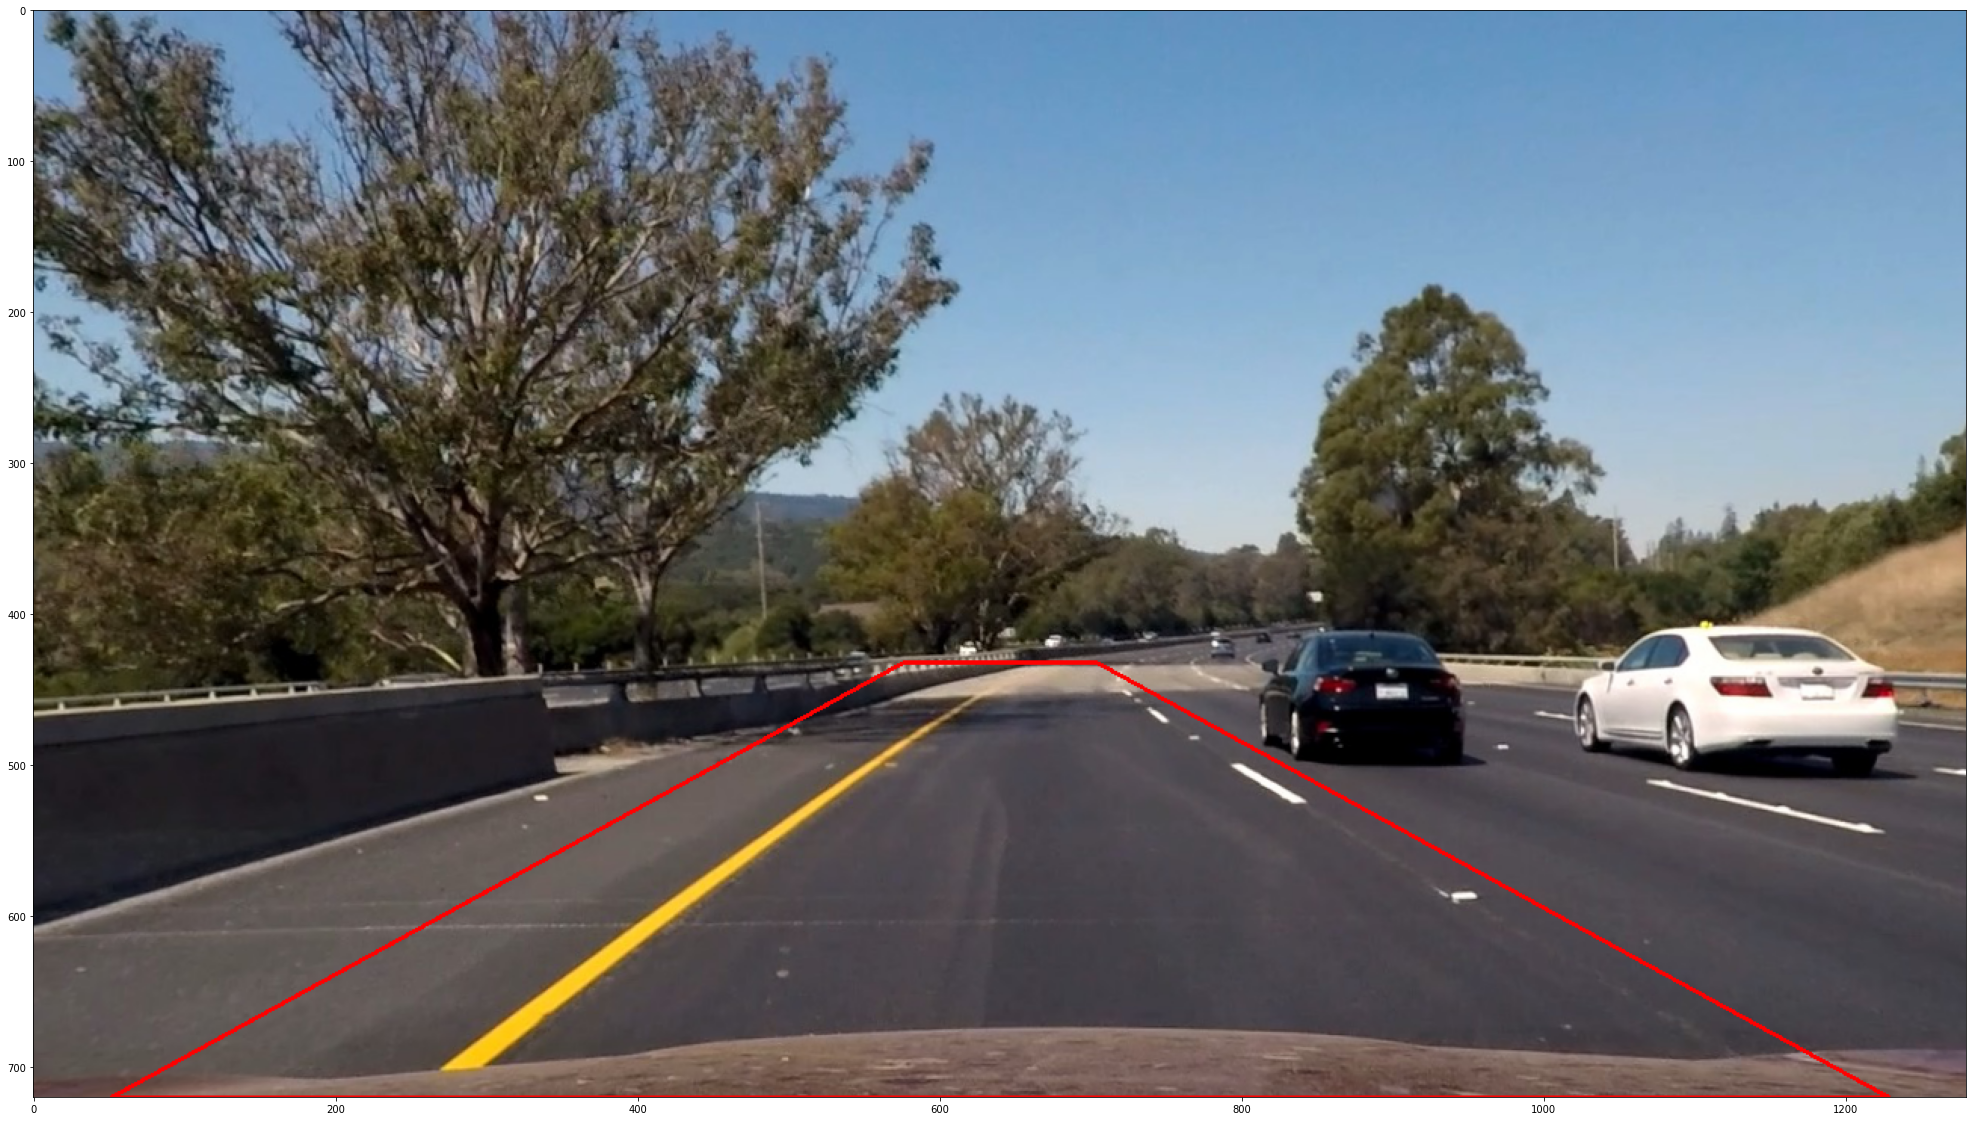

In [22]:
reference_image_fp = os.path.join(RAW_IMAGES_DIR, os.listdir(RAW_IMAGES_DIR)[0])
ref_image = plt.imread(reference_image_fp)

undistorted_image = undistort_image(ref_image, camera_matrix=mtx, distortion_matrix=dist)

M, Minv, gray_img_shape = get_perspective_transform(undistorted_image, ref_image, x_proportion_bottom=0.4 / 10, x_proportion_top=4.5 / 10)

In [23]:
for image_name in os.listdir(HIGHLIGHTED_PIXELS_IMAGES_DIR):
    raw_image_path = os.path.join(RAW_IMAGES_DIR, image_name)
    masked_binary_combined_channel = plt.imread(os.path.join(HIGHLIGHTED_PIXELS_IMAGES_DIR, image_name))
    # Convert to grayscale since images are saved as grayscale
    masked_binary_combined_channel = grayscale(masked_binary_combined_channel, format_=IMAGE_FORMAT)
    leftx, lefty, rightx, righty, out_img = get_lane_line_pixels_with_sliding_histogram(
        masked_binary_combined_channel
    )
#     annotated_image = draw_lane_area(raw_image_path, model, left_fit, right_fit, Minv)
    break


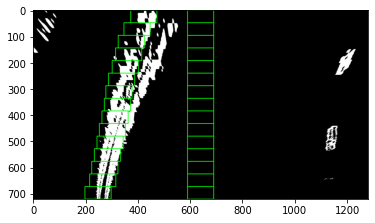

In [24]:
plt.imshow(out_img)

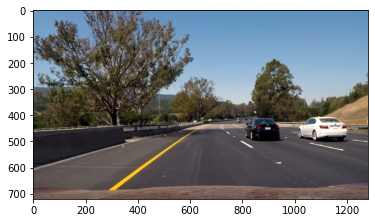

In [18]:
plt.imshow(plt.imread(raw_image_path))

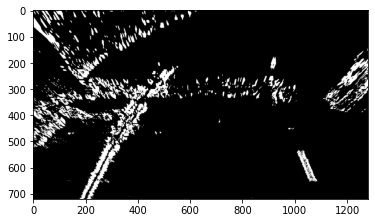

In [10]:
plt.imshow(masked_binary_combined_channel, cmap='gray')

In [ ]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def findLines(image, nwindows=9, margin=110, minpix=50):
    """
    Find the polynomial representation of the lines in the `image` using:
    - `nwindows` as the number of windows.
    - `margin` as the windows margin.
    - `minpix` as minimum number of pixes found to recenter the window.
    - `ym_per_pix` meters per pixel on Y.
    - `xm_per_pix` meters per pixels on X.
    
    Returns (left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)
    """    
    # Make a binary and transform image
    binary_warped = combineAndTransform(image)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)

def visualizeLanes(image, ax):
    """
    Visualize the windows and fitted lines for `image`.
    Returns (`left_fit` and `right_fit`)
    """
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = findLines(image)
    # Visualization
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ax.imshow(out_img)
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    return ( left_fit, right_fit, left_fit_m, right_fit_m )

def showLaneOnImages(images, cols = 2, rows = 3, figsize=(15,13)):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    Returns a collection with the image paths and the left and right polynomials.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    imageAndFit = []
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            left_fit, right_fit, left_fit_m, right_fit_m = visualizeLanes(image, ax)
            ax.set_title(imagePathName)
            ax.axis('off')
            imageAndFit.append( ( imagePathName, left_fit, right_fit, left_fit_m, right_fit_m ) )
    return imageAndFit

imagesPoly = showLaneOnImages(testImages)

In [22]:
# single_channel_binary= masked_binary_combined_channel
# nwindows = 15
# # Set height of windows - based on nwindows above and image shape
# window_height = np.int(single_channel_binary.shape[0] // nwindows)
# m, n = single_channel_binary.shape

# # Get the lane starting points
# histogram = np.sum(single_channel_binary[m-window_height:m, :], axis=0)
# # Create an output image to draw on and visualize the result
# out_img = np.dstack((single_channel_binary, single_channel_binary, single_channel_binary))
# # Find the peak of the left and right halves of the histogram
# # These will be the starting point for the left and right lines
# midpoint = np.int(histogram.shape[0] // 2)
# leftx_base = np.argmax(histogram[:midpoint])
# rightx_base = np.argmax(histogram[midpoint:]) + midpoint


In [23]:
# print(leftx_base, rightx_base)

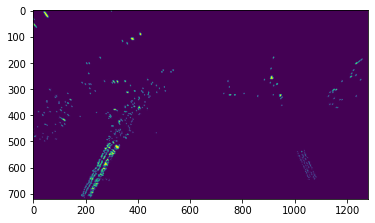

In [24]:
plt.imshow(masked_binary_combined_channel)

In [25]:
lines = hough_lines(
    masked_binary_combined_channel,
    rho=1,
    theta=np.pi/180,
    threshold=100,
    min_line_length=250,
    max_line_gap=200,
)
compute_lanes_from_lines_fn=lane_finder.compute_lanes_from_lines_fn


In [26]:
lines = compute_lanes_from_lines_fn(masked_binary_combined_channel, lines)
annotated_image = draw_lines(masked_binary_combined_channel, lines)

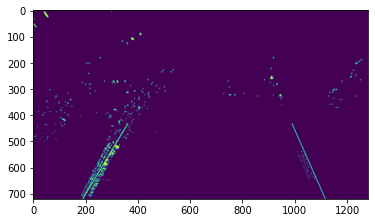

In [27]:
plt.imshow(annotated_image)

In [12]:
lines

array([[[ 189,  720,  362,  432],
        [1117,  720,  989,  432]]])